[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/elepad-org/mlp/blob/main/model/notebook.ipynb)

# 🤖 Multilayer Perceptron

Este Jupyter Notebook implementa una MLP para detectar patrones en una matriz 10x10.
Se genera un dataset para luego entrenar el modelo y validarlo.
Se evalúa la precisión para reiterar sobre el modelo con el objetivo de mejorar su eficacia.
Finalmente se exporta el modelo para ser utilizado en la aplicación web.


## 💡 Situación

En una matriz 10x10 se debe poder detectar las letras `b`, `d`, `f` que se corresponden a los siguientes patrones:

![Patrones que el MLP deberá reconocer](assets/patterns.png)

Se definen en Python los patrones 'b', 'd', y 'f'.
Ante un dato nuevo, el MLP debe ser capaz de clasificar el contenido de la matriz en uno de los tres patrones.


In [11]:
import pandas as pd
import numpy as np
from typing import Literal, TypedDict, Callable
import matplotlib.pyplot as plt

# Extend maximum width when printing DataFrames so they fit in just one line
pd.options.display.width = 100

CLASSES = ["b", "d", "f"]

# fmt: off
# Define the 10x10 patterns for 'b', 'd', and 'f' as a 1D array
PATTERNS = {
    "b": np.array(
           [
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        ],
        dtype=np.uint8,
    ),
    "d": np.array(
        [
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
            0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        ],
        dtype=np.uint8,
    ),
    "f": np.array(
        [
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        ],
        dtype=np.uint8,
    ),
}
# fmt: on

## 🗃️ Generación de Datasets

Los datasets deben ser representativos a la hora de definir la distribución de los ejemplos de entrenamiento.
Conviene generar el conjunto de datos de manera procedural.
Se crea una función `generate_sample` que crea un ejemplo de un patrón dado con una distorsión entre 0 y 0.3.

La distorsión alterna píxeles seleccionados al azar de entre los 100 píxeles de la matriz, transformando ceros en unos y viceversa.
Una distorsión (_noise_) $n$ alterna $\frac{n * 100}{2}$ píxeles, de manera que una distorsión del $100\%$ alterna el valor de $50$ píxeles y alcanza la entropía máxima.


### Reproducibilidad

Para garantizar resultados reproducibles en múltiples ejecuciones de las celdas del notebook, se implementó una función `reset_rng()` que reinicia el generador de números aleatorios (`np.random`) con una semilla (`SEED`) definida. Esta función se llama al generar los datasets originales y al inicio de cada entrenamiento para producir los mismos resultados en múltiples ejecuciones de la misma celda.

In [12]:
# Set seed for reproducibility
SEED = 12345
np.random.seed(SEED)


def reset_rng():
    """
    Reset the RNG seed.
    This ensures reproducibility across multiple runs in the same cell.
    """
    np.random.seed(SEED)


def generate_sample(pattern: Literal["b", "d", "f"], noise: float = 0.0) -> np.ndarray:
    """
    Generates a 1D array based on a given pattern letter ('b', 'd', or 'f'), with optional noise.
    A given noise (between 0 and 1) flips `noise * 100 / 2` pixels, such that a noise
    of 1 flips half the matrix (maximal entropy).

    Args:
        pattern: One of 'b', 'd', or 'f'.
        noise: Proportion of pixels to flip. A noise of 30% will flip 15 out of 100 pixels.
    Returns:
        A numpy 1D array representing the 10x10 matrix with the pattern and noise applied.
    """
    sample = PATTERNS[pattern].copy()
    num_pixels = sample.size
    num_noisy = int(noise * num_pixels / 2)

    if num_noisy > 0:
        # Choose random indices to flip
        indices = np.random.choice(num_pixels, num_noisy, replace=False)
        # Flip the selected pixels (0 becomes 1, 1 becomes 0)
        sample[indices] = 1 - sample[indices]

    return sample


def bold(str: str) -> str:
    """Returns the provided string wrapped in ANSI codes for bold text."""
    return f"\033[1m{str}\033[0m"


def print_sample(sample: np.ndarray):
    """Pretty-prints the provided 1D array as a 10x10 matrix."""
    GREEN = "\033[92m"
    GRAY = "\033[90m"
    RESET = "\033[0m"
    for i in range(10):
        row = sample[i * 10 : (i + 1) * 10]
        print(
            " ".join(
                [bold(f"{GREEN}1{RESET}") if v else f"{GRAY}0{RESET}" for v in row]
            )
        )


print("A 'b' sample with zero noise:")
print_sample(generate_sample("b", 0.00))
print()
print("A 'b' sample with 30% noise, meaning 15 cells have been randomly flipped:")
print_sample(generate_sample("b", 0.30))

A 'b' sample with zero noise:
0 0 0 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0
0 0 1 1 1 1 1 0 0 0
0 0 1 0 0 0 0 1 0 0
0 0 1 0 0 0 0 1 0 0
0 0 1 0 0 0 0 1 0 0
0 0 1 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0

A 'b' sample with 30% noise, meaning 15 cells have been randomly flipped:
0 0 0 0 1 0 0 0 0 0
0 0 1 1 0 0 0 0 0 0
1 0 1 0 0 0 0 0 1 0
0 0 1 1 0 1 0 0 0 0
0 0 0 1 1 1 1 0 0 1
0 1 1 0 0 0 0 1 0 0
1 0 1 1 0 0 0 1 0 1
0 0 1 0 0 0 0 1 1 0
0 0 1 1 1 1 0 0 1 0
0 0 0 0 0 0 0 0 0 0


Luego se generan 3 datasets que contengan 100, 500 y 1000 ejemplos. 
El 10% son patrones sin distorsionar y el resto presentan una distorsión del 1% al 30%.
Se usa una **distribución uniforme** para ubicar el 90% de ejemplos en el rango de distorsión entre 0.01 y 0.30.

Cada dataset es un `pd.DataFrame` de `pandas` que contiene columnas del `0` al `99` (una por cada celda de la matriz) y una columna final `class` que indica la clase del patrón ('b', 'd' o 'f').


In [13]:
def generate_dataset(n_samples: int) -> pd.DataFrame:
    """
    Generates a dataset of pattern samples.
    The 90% of samples will have noise between 0.01 and 0.30.
    Args:
        n_samples: Number of samples to generate.
    Returns:
        A dataframe with 100 columns for the pattern and 1 column 'class' for the pattern class.
    """
    columns = [str(i) for i in range(100)] + ["class"]
    df = pd.DataFrame(0, index=np.arange(n_samples), columns=columns)
    df = df.astype({"class": "str"})

    for i in range(n_samples):
        # 10% without distortion, 90% with distortion between 1% and 30%
        if i < int(0.1 * n_samples):
            noise = 0.0
        else:
            noise = np.random.uniform(0.01, 0.30)

        # Pick a pattern at random
        pattern = np.random.choice(list(PATTERNS.keys()))

        sample = generate_sample(pattern, noise).flatten()
        df.iloc[i, :100] = sample
        df.loc[i, "class"] = pattern

    return df


# Reset RNG for reproducibility across multiple runs
reset_rng()

DATASET_SIZES = [100, 500, 1000]
original_datasets = [generate_dataset(size) for size in DATASET_SIZES]

print("Dataset de 1000 ejemplos:")
original_datasets[2]

Dataset de 1000 ejemplos:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,class
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,b
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,f
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,b
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,f
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,b
996,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,b
997,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,b
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,d


Por cada dataset se construyen tres conjuntos de validación con 10%, 20% y 30% de los ejemplos, implicando conjuntos de entrenamiento del 90%, 80% y 70%.
Eso da un total de 9 pares de datasets:

| Dataset | Cantidad de Ejemplos | % Entrenamiento | % Validación |
|----|--------------------|-----------------|-------------|
|  1 | 100                | 90%             | 10%         |
|  2 | 100                | 80%             | 20%         |
|  3 | 100                | 70%             | 30%         |
|  4 | 500                | 90%             | 10%         |
|  5 | 500                | 80%             | 20%         |
|  6 | 500                | 70%             | 30%         |
|  7 | 1000               | 90%             | 10%         |
|  8 | 1000               | 80%             | 20%         |
|  9 | 1000               | 70%             | 30%         |

In [14]:
def split_dataset(
    df: pd.DataFrame, validation_ratio: float
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the dataset into training and validation sets.
    Args:
        df: The dataset to split.
        validation_ratio: Proportion of the dataset to include in the validation set.
    Returns:
        tuple: (training_df, validation_df).
    """
    shuffled_df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    validation_size = int(len(df) * validation_ratio)
    validation_df = shuffled_df.iloc[:validation_size].reset_index(drop=True)
    training_df = shuffled_df.iloc[validation_size:].reset_index(drop=True)
    return training_df, validation_df


def get_dataset_name(n_samples: int, validation_ratio: float):
    """Returns dataset name for a given number of samples and validation ratio."""
    return f"samples={n_samples},val_ratio={int(validation_ratio * 100)}%"


VALIDATION_RATIOS = [0.1, 0.2, 0.3]

# Store all datasets in one dictionary
datasets: dict[str, tuple[pd.DataFrame, pd.DataFrame]] = {}
for df in original_datasets:
    for validation_ratio in VALIDATION_RATIOS:
        training, validation = split_dataset(df, validation_ratio)
        n_samples = df.shape[0]
        key = get_dataset_name(n_samples, validation_ratio)
        datasets[key] = (training, validation)

## 🧠 Implementación del Modelo

Se debe implementar el algoritmo MLP que permita, dado un dataset, parametrizar la cantidad de capas, neuronas y funciones de activación con los que se entrenará la red neuronal.

Requerimientos para la arquitectura del modelo:

- 1 o 2 capas ocultas.
- De 5 a 10 neuronas por capa.
- Funciones de activación: lineal y sigmoidal.
- Coeficiente de aprendizaje entre 0 y 1.
- Término momento entre 0 y 1.

Se estudia el algoritmo utilizando de referencia la bibliografía recomendada por la cátedra [disponible en el campus virtual](https://frre.cvg.utn.edu.ar/pluginfile.php/105673/mod_label/intro/Perceprtr%C3%B3n-MLP.pdf):

- Hilera, J. R. Martinez, V. J. (2000) Redes Neuronales Artificiales. Fundamentos, modelos y aplicaciones. Alfaomega.

También se consulta material complementario para resolver dudas durante la implementación:

- Prince, S. J. D. (2023). Understanding deep learning. The MIT Press. [http://udlbook.com](http://udlbook.com).

### Arquitectura

La arquitectura de esta red neuronal feedforward (MLP) consiste en:

- **Capa de entrada:** 100 neuronas, una por cada celda de la matriz.
- **Capa oculta 1:** 10 neuronas.
- **Capa oculta 2:** 5 neuronas.
- **Capa de salida:** 3 neuronas, una para la clasificación de cada patrón 'b', 'd', 'f'.

Próximamente los hiperparámetros serán parametrizables, pero actualmente se utiliza esta arquitectura como base. 
Los parámetros son inicializados mediante la técnica de Xavier Glorot, y el entrenamiento del MLP consiste en ajustar estos parámetros hasta lograr una pérdida (_loss_) menor a cierta tolerancia.

![Diagrama de la arquitectura del MLP](assets/architecture.png)

Esta red neuronal es una función $f[X, \phi] = Y$ que clasifica el contenido de una matriz 10x10 en uno de tres patrones.
El contenido de la matriz 10x10 se representa como el vector de entrada $X = [x_1, x_2, \dots, x_{100}]^T$.
El vector de salida $Y = [y_b, y_d, y_f]^T$ contiene la predicción del modelo para cada patrón.
El conjunto de parámetros $\phi = \{B_k, W_k\}_{k=0}^K$ del modelo contiene:

- El vector de _biases_ $B_k$ que contribuyen a la capa $k+1$. Es de tamaño $D_{k+1}$.
- Los pesos (_weights_) $W_k$ aplicados a la capa $k$ y que contribuyen a la capa $k+1$. Es de tamaño $D_{k+1} \times D_k$.

La red neuronal se puede representar utilizando notación matricial:

$$
\begin{aligned}
X &= [x_1, x_2, \dots, x_{100}]^T \\
H_1 &= a \left[ B_{1} + W_{1} X \right] \\
H_2 &= a \left[ B_{2} + W_{2} H_1 \right] \\
Y &= B_3 + W_{3} H_2 \\
\end{aligned}
$$

donde $a[\bullet]$ es una función que aplica la función de activación por separado a cada elemento de su vector de entrada.

Esa notación se puede expandir de la siguiente manera (Prince, 2023, p. 48):

$$
\quad \quad \quad \quad \quad
\begin{aligned}
H_1 &= \begin{bmatrix} h_1 \\ h_2 \\ \vdots \\ h_{10} \end{bmatrix} = a \left[ \begin{bmatrix}
b_{1} \\
b_{2} \\
\vdots \\
b_{10}
\end{bmatrix} + \begin{bmatrix}
w_{11} & w_{12} & \dots & w_{1\, 100} \\
w_{21} & w_{22} & \dots & w_{2\ 100} \\
\vdots & \vdots & \ddots & \vdots \\
w_{10 \ 1} & w_{10\, 2} & \dots & w_{10\ 100} \\
\end{bmatrix} \begin{bmatrix}
x_{1} \\
x_{2} \\
\vdots \\
x_{100}
\end{bmatrix} \right]  \\
\end{aligned}
$$

$$
\quad \quad \ \
\begin{aligned}
H_2 &= \begin{bmatrix}
h'_1 \\
h'_2 \\
\vdots \\
h'_5
\end{bmatrix} = a
\left[
\begin{bmatrix}
b'_{1} \\
b'_{2} \\
\vdots \\
b'_{5}
\end{bmatrix}
+
\begin{bmatrix}
w'_{11} & w'_{12} & \dots & w'_{1\ 10} \\
w'_{21} & w'_{22} & \dots & w'_{2\ 10} \\
\vdots & \vdots & \ddots & \vdots \\
w'_{51} & w'_{52} & \dots & w'_{5\ 10} \\
\end{bmatrix}
\begin{bmatrix}
h_{1} \\
h_{2} \\
\vdots \\
h_{10}
\end{bmatrix}
\right]  \\
\end{aligned}
$$

$$
\begin{aligned}
Y &=
\begin{bmatrix}
y_b \\
y_d \\
y_f
\end{bmatrix}
= \begin{bmatrix}
b''_{1} \\
b''_{2} \\
b''_{3}
\end{bmatrix}
+ \begin{bmatrix}
w''_{11} & w''_{12} & \dots & w''_{14} \\
w''_{21} & w''_{22} & \dots & w''_{24} \\
w''_{31} & w''_{32} & \dots & w''_{34} \\
\end{bmatrix}
\begin{bmatrix}
h'_{1} \\
h'_{2} \\
\vdots \\
h'_{5}
\end{bmatrix} \\
\end{aligned}
$$

Por ejemplo, la activación de la segunda neurona de la primera capa oculta se calcula como $h_2 = a[b_2 + w_{21}x_1 + \dots + w_{2\ 100}x_{100}]$.

A diferencia de Prince, Hilera & Martinez sí agregan una función de activación posterior a la capa de salida del MLP.
Para mantener este trabajo alineado con la bibliografía de la cátedra, se prioriza seguir la implementación de Hilera & Martinez.

### Funciones de Activación

Si bien existen múltiples funciones de activación, este trabajo práctico requiere dos en particular:

- Lineal.
- Sigmoidal.

![Funciones de activación](assets/activation_functions.png)


### Regla de Aprendizaje

Se debe elegir la regla de aprendizaje o _loss function_ a utilizar.
Hilera & Martinez (p. 119) presentan la regla _Least Mean Squared_ o _regla delta_:

$$
\epsilon_k^2 = \frac{1}{2L} \sum_{k=1}^L (d_k - s_k)^2
$$


mientras que Prince (p. 62) presenta una función _Least Squares_ similar que omite el coeficiente constante:

$$
L[\phi] = \sum_{i=1}^I (y_i - f[X_i, \phi])^2
$$

Ambas consisten en comparar la salida obtenida contra la deseada para obtener el costo o pérdida.
El costo se debería reducir en cada iteración del entrenamiento del MLP a medida que se ajustan los parámetros.


### Momento

El _momento_ es una modificación al algoritmo _backpropagation_ del gradiente descendiente para suavizar el progreso del algoritmo y evitar oscilaciones.
Matemáticamente es un coeficiente $\beta$ que se agrega para considerar el valor de un parámetro en la iteración anterior al momento de calcular su nuevo valor en la iteración siguiente.

Hilera & Martinez (p. 135) lo presentan como:

$$
\begin{aligned}
w_{ji} (t+1) &= w_{ji}(t) + \alpha \ \delta_{pj}y_{pi} + \underbrace {\beta (w_{ji}(t) - w_{ji} (t-1))}_\text{Término momento} \\
\Delta w_{ji} (t+1) &= \alpha \ \delta_{pj}y_{pi} + \beta \ \Delta w_{ji} (t) \\
\end{aligned}
$$

mientras que Prince (p. 86) lo presenta como:

$$
\begin{aligned}
\mathbf{m}_{t+1} &\leftarrow \beta \cdot \mathbf{m}_t 
  + (1 - \beta) \sum_{i \in \mathcal{B}_t} 
  \frac{\partial \ell_i[\boldsymbol{\phi}_t]}{\partial \boldsymbol{\phi}} \\[6pt]
\boldsymbol{\phi}_{t+1} &\leftarrow 
  \boldsymbol{\phi}_t - \alpha \cdot \mathbf{m}_{t+1}
\end{aligned}
$$

In [15]:
EXPECTED_OUTPUT = {
    "b": np.array([1, 0, 0]),
    "d": np.array([0, 1, 0]),
    "f": np.array([0, 0, 1]),
}


def get_sample_and_expected_output(
    dataset: pd.DataFrame, i: int
) -> (np.array, np.array):
    """Given an index of the dataset, return a sample and its expected output."""
    sample = np.array(dataset.iloc[i, :100].values, dtype=np.float64)
    d = EXPECTED_OUTPUT[dataset.iloc[i, 100]]
    return sample, d


def sigmoid_stable(x):
    """
    Numerically stable sigmoid function to avoid overflow.
    Uses clipping to prevent extreme values.
    """
    x_clipped = np.clip(x, -700, 700)
    return 1.0 / (1.0 + np.exp(-x_clipped))


def sigmoid_derivative_stable(x):
    """Numerically stable sigmoid derivative."""
    s = sigmoid_stable(x)
    return s * (1 - s)


class MLP:
    """Multilayer Perceptron for pattern recognition."""

    def __init__(
        self,
        activation_type: Literal["sigmoid", "linear"] = "sigmoid",
        learning_rate: float = 0.1,
        momentum: float = 0.1,
    ):
        """
        Initialize the MLP with specified hyperparameters.
        Args:
            activation_type: Activation function type ("sigmoid" or "linear")
            learning_rate: Learning rate for gradient descent
            momentum: Momentum coefficient for parameter updates
        """
        self.activation_type = activation_type
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.params = self.initialize_parameters()

    def initialize_parameters(self) -> dict[str, np.ndarray]:
        """
        Initialize weights and biases using Xavier initialization, where each
        parameter will be drawn from a normal distribution with mean of `0` and
        a standard deviation of `sqrt(2 / (input_layer_size + output_layer_size))`
        to help prevent vanishing or exploding gradients.
        """
        # Initialize layer 1 parameters (input -> hidden1)
        std1 = np.sqrt(2.0 / (100 + 10))
        W1 = np.random.normal(0, std1, (10, 100))
        b1 = np.zeros(10)

        # Initialize layer 2 parameters (hidden1 -> hidden2)
        std2 = np.sqrt(2.0 / (10 + 5))
        W2 = np.random.normal(0, std2, (5, 10))
        b2 = np.zeros(5)

        # Initialize output layer parameters (hidden2 -> output)
        std3 = np.sqrt(2.0 / (5 + 3))
        W3 = np.random.normal(0, std3, (3, 5))
        b3 = np.zeros(3)

        return {
            "W1": W1,
            "b1": b1,
            "W2": W2,
            "b2": b2,
            "W3": W3,
            "b3": b3,
            "delta_W1": np.zeros_like(W1),
            "delta_b1": np.zeros_like(b1),
            "delta_W2": np.zeros_like(W2),
            "delta_b2": np.zeros_like(b2),
            "delta_W3": np.zeros_like(W3),
            "delta_b3": np.zeros_like(b3),
        }

    def get_activation_function(self):
        """Return the activation function based on activation type."""
        if self.activation_type == "sigmoid":
            return sigmoid_stable
        elif self.activation_type == "linear":
            return lambda x: x

    def get_activation_derivative(self):
        """Return the derivative of the activation function based on activation type."""
        if self.activation_type == "sigmoid":
            return sigmoid_derivative_stable
        elif self.activation_type == "linear":
            return lambda x: np.ones_like(x)

    def feedforward(self, X: np.ndarray) -> np.ndarray:
        """
        Perform a feedforward pass through the network.
        See: Prince, 2023 (page 103) or Hilera & Martinez, 2000 (pages 138-139).
        Args:
            X: Input pattern (100 values).
        Returns:
            Array with all neuron activations at each layer [X, h1, h2, y].
        """
        a = self.get_activation_function()

        # Forward pass from input layer to hidden layer 1
        h1 = a(self.params["b1"] + np.dot(self.params["W1"], X))

        # Forward pass from hidden layer 1 to hidden layer 2
        h2 = a(self.params["b2"] + np.dot(self.params["W2"], h1))

        # Forward pass from hidden layer 2 to output layer
        y = a(self.params["b3"] + np.dot(self.params["W3"], h2))

        return [X, h1, h2, y]

    def backpropagation(self, X: np.ndarray, d: np.ndarray, activations: list) -> dict:
        """
        Backpropagation. See: Hilera & Martinez, 2000 (pages 133-142).
        Args:
            X: Input pattern (100 values).
            d: Target output (3 values).
            activations: Neuron activations from forward pass [X, h1, h2, y_pred].
        Returns:
            Dictionary with updated parameters.
        """
        _, h1, h2, y_pred = activations
        a_derived = self.get_activation_derivative()

        # Output layer (see page 134-135)
        delta3 = (d - y_pred) * a_derived(y_pred)

        delta_W3 = (
            self.learning_rate * np.outer(delta3, h2)
            + self.momentum * self.params["delta_W3"]
        )
        delta_b3 = self.learning_rate * delta3 + self.momentum * self.params["delta_b3"]

        # Hidden layer 2 (see page 135)
        delta2 = np.dot(self.params["W3"].T, delta3) * a_derived(h2)

        delta_W2 = (
            self.learning_rate * np.outer(delta2, h1)
            + self.momentum * self.params["delta_W2"]
        )
        delta_b2 = self.learning_rate * delta2 + self.momentum * self.params["delta_b2"]

        # Hidden layer 1 (see page 135)
        delta1 = np.dot(self.params["W2"].T, delta2) * a_derived(h1)

        delta_W1 = (
            self.learning_rate * np.outer(delta1, X)
            + self.momentum * self.params["delta_W1"]
        )
        delta_b1 = self.learning_rate * delta1 + self.momentum * self.params["delta_b1"]

        # Update parameters (see page 135)
        new_params = self.params.copy()
        new_params["W1"] += delta_W1
        new_params["b1"] += delta_b1
        new_params["W2"] += delta_W2
        new_params["b2"] += delta_b2
        new_params["W3"] += delta_W3
        new_params["b3"] += delta_b3

        # Update momentum terms (see page 135)
        new_params["delta_W1"] = delta_W1
        new_params["delta_b1"] = delta_b1
        new_params["delta_W2"] = delta_W2
        new_params["delta_b2"] = delta_b2
        new_params["delta_W3"] = delta_W3
        new_params["delta_b3"] = delta_b3

        return new_params

    def calculate_loss(self, d: np.ndarray, s: np.ndarray) -> float:
        """Compute least mean squared error loss. See: Hilera & Martinez, 2000 (page 119)."""
        return (1 / (2 * len(d))) * np.sum((d - s) ** 2)

    def classify(self, X: np.ndarray) -> str:
        """
        Classify the input pattern into a class.
        Args:
            X: Input pattern (100 values).
        Returns:
            "b", "d", or "f" according to the maximal output neuron.
        """
        y_pred = self.feedforward(X)[-1]
        idx = int(np.argmax(y_pred))
        return CLASSES[idx]

    def train(
        self, train_data: pd.DataFrame, val_data: pd.DataFrame, tolerance: float = 1e-5
    ) -> dict:
        """
        Train the MLP on a complete dataset using tolerance-based early stopping.
        Computes training loss and validation loss at each epoch.
        Args:
            train_data: DataFrame with 100 feature columns and a 'class' column.
            val_data: Optional validation DataFrame (same format as train_data).
            tolerance: Minimum difference between losses to continue training.
        Returns:
            Dictionary with training and validation history.
        """
        train_losses = []
        val_losses = []
        prev_avg_loss = float("inf")
        epoch = 0

        print("+-------+---------------+-----------------+")
        print("| Epoch | Training Loss | Validation Loss |")
        print("+-------+---------------+-----------------+")

        while True:
            epoch_loss = 0

            # Training
            for i in range(len(train_data)):
                sample, d = get_sample_and_expected_output(train_data, i)
                activations = self.feedforward(sample)
                y_pred = activations[-1]
                loss = self.calculate_loss(d, y_pred)
                epoch_loss += loss

                self.params = self.backpropagation(sample, d, activations)

            avg_loss = epoch_loss / len(train_data)
            train_losses.append(avg_loss)

            # Validation metrics
            val_epoch_loss = 0
            for i in range(len(val_data)):
                val_sample, val_d = get_sample_and_expected_output(val_data, i)
                val_y_pred = self.feedforward(val_sample)[-1]
                val_loss = self.calculate_loss(val_d, val_y_pred)
                val_epoch_loss += val_loss

            val_avg_loss = val_epoch_loss / len(val_data)
            val_losses.append(val_avg_loss)

            # Print progress
            if epoch % 25 == 0:
                print(f"| {epoch:5} |  {avg_loss:11.10f} |  {val_losses[-1]:11.12f} |")

            # Check for stop condition
            loss_change = abs(avg_loss - prev_avg_loss)
            if loss_change < tolerance:
                print(
                    f"| {epoch:5} |  {avg_loss:11.10f} |  {val_losses[-1]:11.12f} | <-- Stopped"
                )
                print("+-------+---------------+-----------------+")
                break

            prev_avg_loss = avg_loss
            epoch += 1

        return {
            "train_losses": train_losses,
            "val_losses": val_losses,
        }


reset_rng()
print("Simple test with a dataset of just one sample:")
single_sample_df = generate_dataset(1)
sample = np.array(single_sample_df.iloc[0, :100].values, dtype=np.float64)
print_sample(sample)
mlp = MLP("sigmoid", 0.1, 0.1)
mlp.train(single_sample_df, single_sample_df, tolerance=0.00001)
c = mlp.classify(sample)
print(f"Pattern classified into class {bold(c)}.")

Simple test with a dataset of just one sample:
0 0 0 0 0 0 0 0 0 1
0 0 0 0 0 0 0 1 0 0
1 0 0 0 0 0 0 1 1 0
0 0 0 1 0 0 0 1 0 0
0 0 0 1 0 0 1 1 0 0
0 1 1 0 0 0 0 1 1 0
0 0 1 0 0 0 0 1 0 0
1 0 1 0 0 0 1 1 1 1
0 0 0 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0
+-------+---------------+-----------------+
| Epoch | Training Loss | Validation Loss |
+-------+---------------+-----------------+
|     0 |  0.1389112200 |  0.135160435012 |
|    25 |  0.0630456902 |  0.061044698552 |
|    50 |  0.0288067142 |  0.027961504262 |
|    75 |  0.0143742971 |  0.014011055304 |
|   100 |  0.0079618122 |  0.007791568884 |
|   125 |  0.0048303860 |  0.004742515759 |
|   150 |  0.0031519989 |  0.003102610242 |
|   175 |  0.0021780904 |  0.002148300261 |
|   200 |  0.0015749633 |  0.001555927727 |
|   225 |  0.0011810893 |  0.001168337140 |
|   243 |  0.0009781688 |  0.000968373812 | <-- Stopped
+-------+---------------+-----------------+
Pattern classified into class d.


## 🧪 Entrenamiento y Validación

Una vez implementado el MLP con sus algoritmos de feedforward y backpropagation, se puede entrenar el modelo para ajustar los parámetros.
Se entrena un MLP por separado para cada uno de los 9 pares de datasets generados anteriormente.


In [16]:
class TrainingResult(TypedDict):
    dataset_name: str
    mlp: MLP
    epochs: range
    train_losses: list[float]
    val_losses: list[float]


def train_datasets(
    datasets: dict[str, tuple[pd.DataFrame, pd.DataFrame]],
    mlp_factory: Callable[[], MLP | object],
    train_kwargs: dict[str, any] = {},
) -> list[TrainingResult]:
    """
    Train one model per dataset and collect results.
    Args:
        datasets: mapping dataset_name to (train_df, val_df) tuple.
        mlp_factory: function that returns a new MLP or MLP2 instance.
        train_kwargs: optional kwargs forwarded to `mlp.train(...)`.
    Returns:
        list of TrainingResults.
    """
    # Reset RNG before training for reproducibility
    reset_rng()
    results: list[TrainingResult] = []

    for key, (train_data, val_data) in datasets.items():
        print(bold(f"\n# Dataset {key}"))
        mlp = mlp_factory()
        history = mlp.train(train_data, val_data, **train_kwargs)
        results.append(
            {
                "dataset_name": key,
                "mlp": mlp,
                "epochs": range(len(history["train_losses"])),
                "train_losses": history["train_losses"],
                "val_losses": history["val_losses"],
            }
        )

    print(f"All {len(datasets)} MLPs trained.")
    return results


results = train_datasets(
    datasets,
    lambda: MLP("sigmoid", 0.1, 0.1),
    train_kwargs={"tolerance": 0.000001},
)


# Dataset samples=100,val_ratio=10%
+-------+---------------+-----------------+
| Epoch | Training Loss | Validation Loss |
+-------+---------------+-----------------+
|     0 |  0.1143796729 |  0.116190465784 |
|    25 |  0.0429353421 |  0.059291237521 |
|    50 |  0.0137308086 |  0.032958279241 |
|    75 |  0.0013800186 |  0.023902370508 |
|   100 |  0.0002756998 |  0.015440390944 |
|   125 |  0.0001311709 |  0.017088102029 |
|   150 |  0.0000794445 |  0.018683179639 |
|   163 |  0.0000643254 |  0.019462686679 | <-- Stopped
+-------+---------------+-----------------+

# Dataset samples=100,val_ratio=20%
+-------+---------------+-----------------+
| Epoch | Training Loss | Validation Loss |
+-------+---------------+-----------------+
|     0 |  0.1151500633 |  0.110814463745 |
|    25 |  0.0498315421 |  0.054673864752 |
|    50 |  0.0037817773 |  0.004640950407 |
|    75 |  0.0009077621 |  0.002485013568 |
|   100 |  0.0004647404 |  0.003525765673 |
|   125 |  0.0002802949 |  0.00431

Una vez entrenado un modelo para el dataset de entrenamiento de cada conjunto de datos, se utiliza el dataset de validación asociado para probar la **generalización** del modelo entrenado a nuevos datos que no haya visto antes.

Se grafican los resultados del modelo a lo largo del entrenamiento:

- La evolución del **error global** o pérdida de entrenamiento.
- La evolución del **error de validación**.

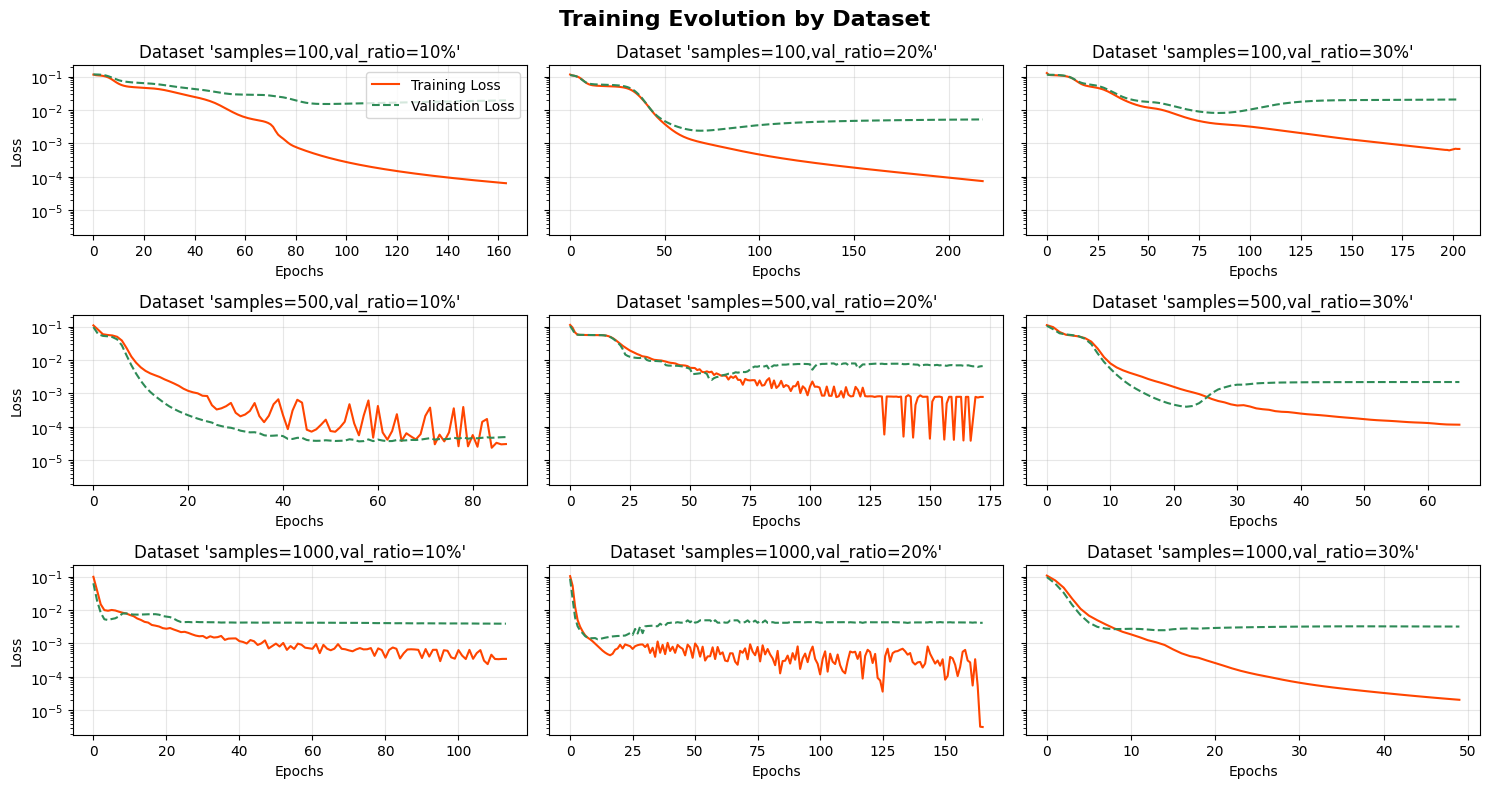

In [17]:
def plot_training_evolution(
    results: list[TrainingResult],
    title: str = "Training Evolution by Dataset",
):
    """
    Plot training and validation loss curves arranged in a grid.
    Args:
        results: list of training results.
        title: figure suptitle.
    """
    fig, axes = plt.subplots(3, 3, figsize=(15, 8), sharey=True)
    fig.suptitle(title, fontsize=16, fontweight="bold")

    for idx, res in enumerate(results):
        ax = axes[idx // 3][idx % 3]
        ax.plot(
            res["epochs"], res["train_losses"], color="orangered", label="Training Loss"
        )
        ax.plot(
            res["epochs"],
            res["val_losses"],
            color="seagreen",
            linestyle="--",
            label="Validation Loss",
        )

        ax.set_yscale("log")
        ax.set_title(f"Dataset '{res['dataset_name']}'")
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("Epochs")

        # Set loss label on first column
        if idx % 3 == 0:
            ax.set_ylabel("Loss")

        # Add legend only to the first subplot
        if idx == 0:
            ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


plot_training_evolution(results, title="Training Evolution by Dataset")

In [18]:
def compute_validation_accuracies(
    results: list[TrainingResult], datasets: (pd.DataFrame, pd.DataFrame)
) -> list[float]:
    """Return an array with the validation accuracy of each dataset."""
    accuracies = []
    sorted_results = sorted(results, key=lambda res: res["dataset_name"])

    for res in sorted_results:
        mlp = res["mlp"]
        dataset_name = res["dataset_name"]
        _, val_data = datasets[dataset_name]

        samples = val_data.iloc[:, :100].values.astype(np.float64)
        expected_classes = val_data.iloc[:, 100].values

        predictions = np.array([mlp.classify(sample) for sample in samples])

        accuracy = np.mean(predictions == expected_classes)
        accuracies.append(accuracy)

    return accuracies


# Dataframe that will accumulate validation accuracies to compare between experiments.
accuracies = pd.DataFrame({"Dataset": sorted(datasets.keys())})
accuracies["Accuracy (original)"] = compute_validation_accuracies(results, datasets)
accuracies

,Dataset,Accuracy (original)
0,"samples=100,val_ratio=10%",0.900000
1,"samples=100,val_ratio=20%",0.950000
2,"samples=100,val_ratio=30%",0.933333
3,"samples=1000,val_ratio=10%",0.990000
4,"samples=1000,val_ratio=20%",0.980000
5,"samples=1000,val_ratio=30%",0.986667
6,"samples=500,val_ratio=10%",1.000000
7,"samples=500,val_ratio=20%",0.980000
8,"samples=500,val_ratio=30%",0.993333


## 🪛 Parametrización y Optimización del Modelo

Se han usado los datasets generados para entrenar el MLP implementado y así evaluar su precisión.
Se observa que el modelo no entrena bien en ciertos datasets, y por ende logra una precisión menor en esos casos.
Se quiere **mejorar la precisión del modelo**, para lo cual es necesario ajustar el modelo y mejorar su entrenamiento.

Se lo puede ajustar de varias maneras:

- Usar otra función de activación.
- Modificar la inicialización de los parámetros.
- Probar otros optimizadores (ej: gradiente descendiente estocástico).
- Cambiar la cantidad de capas.
- Cambiar la cantidad de neuronas de cada capa.

Para poder variar los hiperparámetros del modelo, se desarrolla un `MLP2` más complejo que permita esta parametrización y además incluya nuevas optimizaciones.
Luego se vuelve a entrenar el modelo para distintas combinaciones de hiperparámetros para encontrar los que logren un mejor comportamiento.
Finalmente se analiza el impacto de los hiperparámetros en el entrenamiento del modelo para derivar conclusiones.


In [19]:
class MLP2:
    """Multilayer Perceptron with configurable hyperparameters."""

    def __init__(
        self,
        layers: tuple[int, ...] = (100, 10, 5, 3),
        activation_type: Literal["sigmoid", "linear"] = "sigmoid",
        learning_rate: float = 0.1,
        momentum: float = 0.1,
    ):
        """
        Args:
            layers: Tuple with sizes of input, hidden and output layers.
            activation_type: 'sigmoid' or 'linear'.
            learning_rate: Learning rate for updates.
            momentum: Momentum coefficient for parameter updates.
        """
        self.layers = [int(x) for x in layers]
        self.input_size = self.layers[0]
        self.output_size = self.layers[-1]

        self.activation_type = activation_type
        self.learning_rate = float(learning_rate)
        self.momentum = float(momentum)

        # parameters stored as "W{i}", "b{i}", and momentum deltas "delta_W{i}", "delta_b{i}"
        self.params = self.initialize_parameters()

    def initialize_parameters(self) -> dict[str, np.ndarray]:
        """Xavier-like parameter initialization for an arbitrary number of layers."""
        params: dict[str, np.ndarray] = {}

        for i in range(len(self.layers) - 1):
            in_dim = self.layers[i]
            out_dim = self.layers[i + 1]
            std = np.sqrt(2.0 / (in_dim + out_dim))
            W = np.random.normal(0.0, std, size=(out_dim, in_dim))
            b = np.zeros(out_dim, dtype=float)

            params[f"W{i}"] = W
            params[f"b{i}"] = b
            params[f"delta_W{i}"] = np.zeros_like(W)
            params[f"delta_b{i}"] = np.zeros_like(b)

        return params

    def get_activation_function(self):
        if self.activation_type == "sigmoid":
            return sigmoid_stable
        elif self.activation_type == "linear":
            return lambda x: x

    def get_activation_derivative(self):
        if self.activation_type == "sigmoid":
            return sigmoid_derivative_stable
        elif self.activation_type == "linear":
            return lambda x: np.ones_like(x)

    def feedforward(self, X: np.ndarray):
        """Forward pass adapted for mini-batch processing."""
        act = self.get_activation_function()
        activations = [X]
        a = X

        for i in range(len(self.layers) - 1):
            W = self.params[f"W{i}"]
            b = self.params[f"b{i}"]
            z = b + np.dot(a, W.T)
            a = act(z)
            activations.append(a)

        return activations

    def backpropagation(self, X: np.ndarray, d: np.ndarray, activations: list) -> None:
        """Backpropagation that updates self.params. Adapted for mini-batch processing."""
        a_derived = self.get_activation_derivative()
        L = len(self.layers) - 1
        batch_size = X.shape[0]

        # Output layer deltas for all samples of the batch
        a_L = activations[-1]
        deltas = [(d - a_L) * a_derived(a_L)]  # Shape: (batch_size, output_size)

        # Backward pass
        for i in reversed(range(L)):
            a_prev = activations[i]
            delta = deltas[-1]

            # Average gradients across the batch
            grad_W = np.dot(delta.T, a_prev) / batch_size
            grad_b = np.mean(delta, axis=0)

            # Update with momentum
            delta_W = (
                self.learning_rate * grad_W + self.momentum * self.params[f"delta_W{i}"]
            )
            delta_b = (
                self.learning_rate * grad_b + self.momentum * self.params[f"delta_b{i}"]
            )

            self.params[f"W{i}"] += delta_W
            self.params[f"b{i}"] += delta_b
            self.params[f"delta_W{i}"] = delta_W
            self.params[f"delta_b{i}"] = delta_b

            # Compute deltas for previous layer (except for input layer when i == 0)
            if i > 0:
                W_current = self.params[f"W{i}"]
                delta_prev = np.dot(delta, W_current) * a_derived(activations[i])
                deltas.append(delta_prev)

    def classify(self, X: np.ndarray):
        """Classify input X."""
        y = self.feedforward(X)[-1]
        idx = int(np.argmax(y))
        return CLASSES[idx]

    def calculate_loss(self, d: np.ndarray, s: np.ndarray) -> float:
        """Least mean squared error."""
        return np.mean((d - s) ** 2) / 2.0

    def validate(self, val_data):
        """Calculate validation average loss. Adapted for mini-batch processing."""
        # Get all validation data as arrays
        val_X = val_data.iloc[:, : self.input_size].values
        val_y = val_data.iloc[:, self.input_size].values
        val_d = np.array([EXPECTED_OUTPUT[y] for y in val_y])

        # Forward pass for the entire validation set
        val_pred = self.feedforward(val_X)[-1]

        return self.calculate_loss(val_d, val_pred)

    def compute_gradients(self, X, d, activations, grad_W, grad_b):
        """Compute gradients without updating parameters (useful for mini-batch SGD)."""
        a_derived = self.get_activation_derivative()
        L = len(self.layers) - 1
        a_L = activations[-1]
        delta = (d - a_L) * a_derived(a_L)

        for i in reversed(range(L)):
            a_prev = activations[i]
            W_current = self.params[f"W{i}"]

            grad_W[f"W{i}"] += np.outer(delta, a_prev)
            grad_b[f"b{i}"] += delta

            if i > 0:
                delta = np.dot(delta, W_current) * a_derived(activations[i])

    def train(
        self,
        train_data: pd.DataFrame,
        val_data: pd.DataFrame,
        tolerance=1e-5,
        lr_decay=0.0,
        batch_size=1,
    ) -> dict:
        """
        Train using sample-by-sample updates.
        Args:
            train_data: training dataset.
            val_data: validation dataset.
            tolerance: minimum acceptable change in average loss (stop condition).
            lr_decay: learning rate decay per 25 epochs (value between 0 and 1).
            batch_size: size of mini-batches for Stochastic Gradient Descent (SGD).
        Returns:
            Dictionary with training and validation loss history.
        """
        train_losses = []
        val_losses = []
        prev_avg_loss = float("inf")

        print("+-------+---------------+-----------------+")
        print("| Epoch | Training Loss | Validation Loss |")
        print("+-------+---------------+-----------------+")

        epoch = 0
        while True:
            epoch_loss = 0.0
            train_shuffled = train_data.sample(frac=1, random_state=SEED).reset_index(
                drop=True
            )

            # mini-batch processing for Stochastic Gradient Descent
            # a batch size of 1 is equivalent to pure SGD (what the previous MLP class does)
            for batch_start in range(0, len(train_shuffled), batch_size):
                batch_end = min(batch_start + batch_size, len(train_shuffled))
                batch = train_shuffled.iloc[batch_start:batch_end]

                # Get batch data as arrays
                X_batch = batch.iloc[:, : self.input_size].values
                y_batch = batch.iloc[:, self.input_size].values
                d_batch = np.array([EXPECTED_OUTPUT[y] for y in y_batch])

                # Forward pass for entire batch
                activations = self.feedforward(X_batch)
                y_pred = activations[-1]

                # Calculate batch loss
                batch_loss = self.calculate_loss(d_batch, y_pred)
                epoch_loss += batch_loss * len(X_batch)

                # Backward pass for entire batch
                self.backpropagation(X_batch, d_batch, activations)

            avg_loss = epoch_loss / len(train_data)
            train_losses.append(avg_loss)

            # Validation
            val_avg_loss = self.validate(val_data)
            val_losses.append(val_avg_loss)

            if epoch % 25 == 0:
                print(f"| {epoch:5} | {avg_loss:11.11f} | {val_avg_loss:11.13f} |")
                # update learning rate
                self.learning_rate = self.learning_rate * (1.0 - lr_decay)

            # check stop condition
            if abs(avg_loss - prev_avg_loss) < tolerance:
                print(
                    f"| {epoch:5} | {avg_loss:11.11f} | {val_losses[-1]:11.13f} | <-- Stopped"
                )
                print("+-------+---------------+-----------------+")
                break

            prev_avg_loss = avg_loss
            epoch += 1

        return {"train_losses": train_losses, "val_losses": val_losses}


reset_rng()
print("Simple test with a dataset of just one sample:")
single_sample_df = generate_dataset(1)
sample = np.array(single_sample_df.iloc[0, :100].values, dtype=np.float64)
print_sample(sample)

mlp2 = MLP2(
    layers=(100, 50, 3),
    activation_type="sigmoid",
    learning_rate=0.1,
    momentum=0.1,
)
mlp2.train(
    single_sample_df, single_sample_df, tolerance=1e-5, lr_decay=0.5, batch_size=50
)
pred = mlp2.classify(sample)
print(f"Pattern classified into class {bold(pred)}.")

Simple test with a dataset of just one sample:
0 0 0 0 0 0 0 0 0 1
0 0 0 0 0 0 0 1 0 0
1 0 0 0 0 0 0 1 1 0
0 0 0 1 0 0 0 1 0 0
0 0 0 1 0 0 1 1 0 0
0 1 1 0 0 0 0 1 1 0
0 0 1 0 0 0 0 1 0 0
1 0 1 0 0 0 1 1 1 1
0 0 0 1 1 1 1 0 0 0
0 0 0 0 0 0 0 0 0 0
+-------+---------------+-----------------+
| Epoch | Training Loss | Validation Loss |
+-------+---------------+-----------------+
|     0 | 0.10333113181 | 0.0838706277381 |
|    25 | 0.00949204466 | 0.0089284087853 |
|    50 | 0.00477140188 | 0.0046648817700 |
|    75 | 0.00361515467 | 0.0035792768584 |
|   100 | 0.00318496596 | 0.0031699918968 |
|   102 | 0.00316180216 | 0.0031543118815 | <-- Stopped
+-------+---------------+-----------------+
Pattern classified into class d.


Una vez implementado el `MLP2`, se experimentará con algunos ajustes para intentar mejorar el entrenamiento del modelo.

### Aumentar el Número de Neuronas por Capa

Se experimenta usar una arquitectura de 2 capas intermedias de 10 neuronas cada una.


# Dataset samples=100,val_ratio=10%
+-------+---------------+-----------------+
| Epoch | Training Loss | Validation Loss |
+-------+---------------+-----------------+
|     0 | 0.12056384983 | 0.1097280328116 |
|    25 | 0.04372336189 | 0.0566339182541 |
|    50 | 0.00149043323 | 0.0071089330019 |
|    75 | 0.00045974777 | 0.0047071475809 |
|   100 | 0.00021113191 | 0.0044756920034 |
|   125 | 0.00011213613 | 0.0044916980007 |
|   150 | 0.00006687084 | 0.0045390019609 |
|   159 | 0.00005692375 | 0.0045565718137 | <-- Stopped
+-------+---------------+-----------------+

# Dataset samples=100,val_ratio=20%
+-------+---------------+-----------------+
| Epoch | Training Loss | Validation Loss |
+-------+---------------+-----------------+
|     0 | 0.12118037003 | 0.1150401367081 |
|    25 | 0.02359337362 | 0.0269259554079 |
|    50 | 0.00121705767 | 0.0058450463696 |
|    75 | 0.00036936037 | 0.0081110042348 |
|   100 | 0.00017132625 | 0.0098401128045 |
|   125 | 0.00009313764 | 0.011654

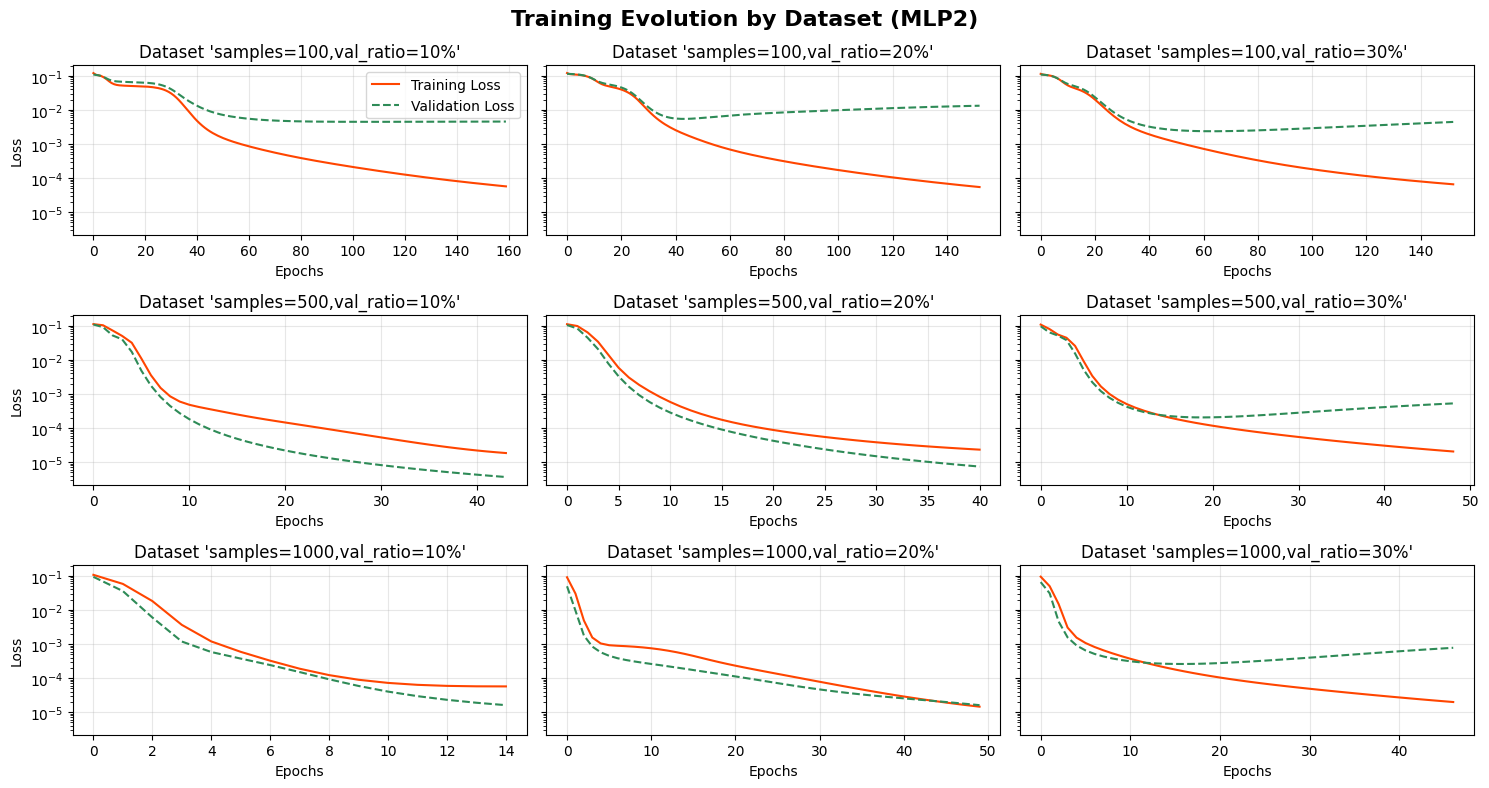

,Dataset,Accuracy (original),Accuracy (neuronas)
0,"samples=100,val_ratio=10%",0.900000,1.000000
1,"samples=100,val_ratio=20%",0.950000,0.950000
2,"samples=100,val_ratio=30%",0.933333,1.000000
3,"samples=1000,val_ratio=10%",0.990000,1.000000
4,"samples=1000,val_ratio=20%",0.980000,1.000000
5,"samples=1000,val_ratio=30%",0.986667,0.996667
6,"samples=500,val_ratio=10%",1.000000,1.000000
7,"samples=500,val_ratio=20%",0.980000,1.000000
8,"samples=500,val_ratio=30%",0.993333,1.000000


In [20]:
results = train_datasets(
    datasets,
    lambda: MLP2((100, 10, 10, 3), "sigmoid", 0.1, 0.1),
    train_kwargs={"tolerance": 0.000001},
)

plot_training_evolution(results, title="Training Evolution by Dataset (MLP2)")
accuracies["Accuracy (neuronas)"] = compute_validation_accuracies(results, datasets)
accuracies

### Variación del Learning Rate

Se prueba disminuir el learning rate un 20% cada 25 épocas para reducir las oscilaciones.


# Dataset samples=100,val_ratio=10%
+-------+---------------+-----------------+
| Epoch | Training Loss | Validation Loss |
+-------+---------------+-----------------+
|     0 | 0.12056384983 | 0.1097280328116 |
|    25 | 0.04836959216 | 0.0636216460996 |
|    50 | 0.00942693664 | 0.0201165483329 |
|    75 | 0.00152526762 | 0.0076371371870 |
|   100 | 0.00082823411 | 0.0057773525805 |
|   125 | 0.00057748903 | 0.0051761277636 |
|   150 | 0.00044923460 | 0.0049140382339 |
|   175 | 0.00037421312 | 0.0047814848379 |
|   200 | 0.00032637219 | 0.0047070424819 |
|   225 | 0.00029396883 | 0.0046618824466 |
|   227 | 0.00029054461 | 0.0046587267342 | <-- Stopped
+-------+---------------+-----------------+

# Dataset samples=100,val_ratio=20%
+-------+---------------+-----------------+
| Epoch | Training Loss | Validation Loss |
+-------+---------------+-----------------+
|     0 | 0.12118037003 | 0.1150401367081 |
|    25 | 0.03901548455 | 0.0453576950519 |
|    50 | 0.00363204420 | 0.006505

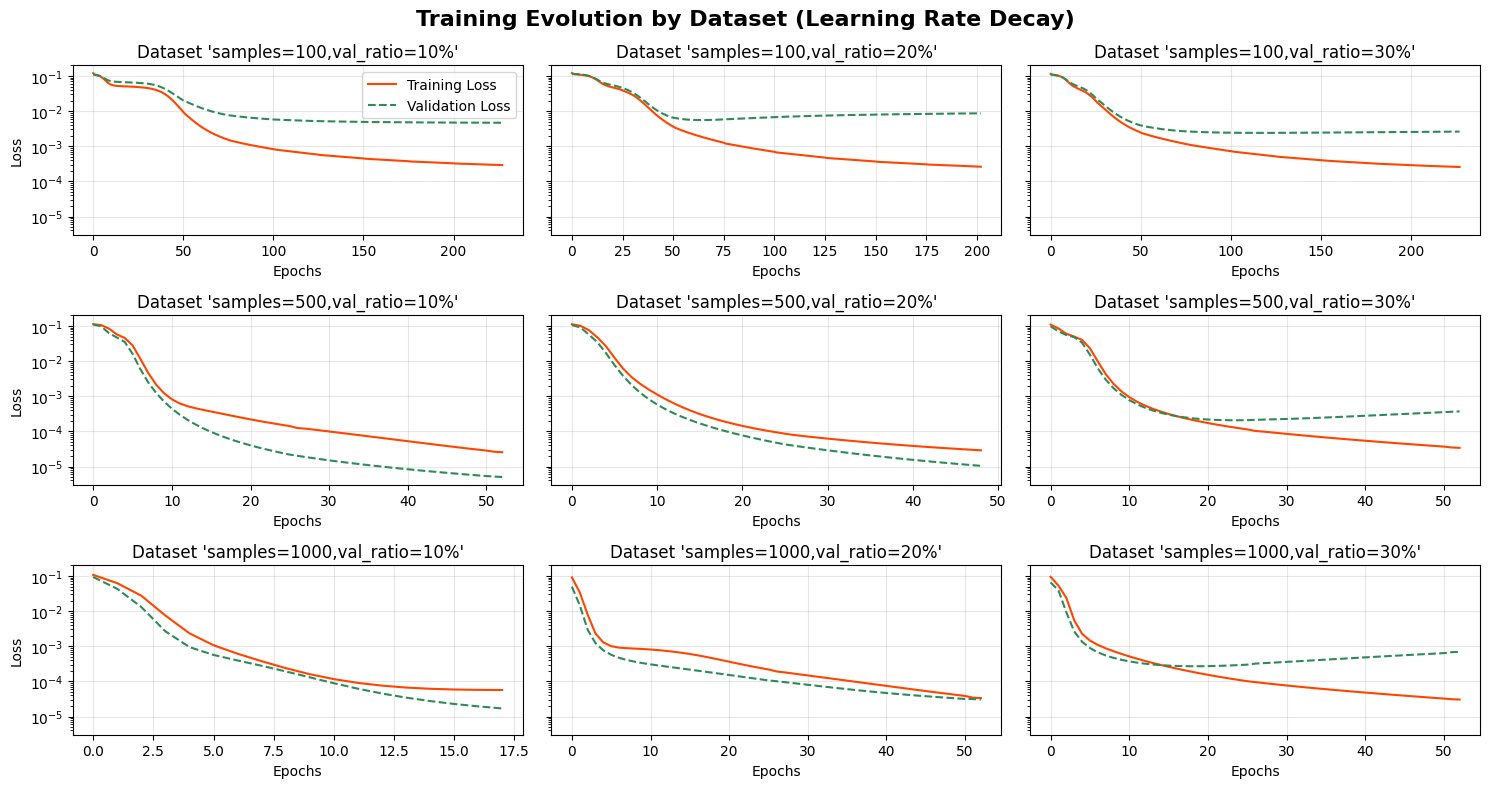

,Dataset,Accuracy (original),Accuracy (neuronas),Accuracy (lr_decay)
0,"samples=100,val_ratio=10%",0.900000,1.000000,1.000000
1,"samples=100,val_ratio=20%",0.950000,0.950000,0.950000
2,"samples=100,val_ratio=30%",0.933333,1.000000,1.000000
3,"samples=1000,val_ratio=10%",0.990000,1.000000,1.000000
4,"samples=1000,val_ratio=20%",0.980000,1.000000,1.000000
5,"samples=1000,val_ratio=30%",0.986667,0.996667,0.996667
6,"samples=500,val_ratio=10%",1.000000,1.000000,1.000000
7,"samples=500,val_ratio=20%",0.980000,1.000000,1.000000
8,"samples=500,val_ratio=30%",0.993333,1.000000,1.000000


In [21]:
results = train_datasets(
    datasets,
    lambda: MLP2((100, 10, 10, 3), "sigmoid", 0.1, 0.1),
    train_kwargs={"tolerance": 0.000001, "lr_decay": 0.2},
)

plot_training_evolution(
    results, title="Training Evolution by Dataset (Learning Rate Decay)"
)
accuracies["Accuracy (lr_decay)"] = compute_validation_accuracies(results, datasets)
accuracies

### Mini-batch SGD

Se utiliza Stochastic Gradient Descent (SGD) con mini-batches para evitar mínimos locales y reducir el ruido del SGD puro.


# Dataset samples=100,val_ratio=10%
+-------+---------------+-----------------+
| Epoch | Training Loss | Validation Loss |
+-------+---------------+-----------------+
|     0 | 0.14193629238 | 0.1307092494411 |
|    25 | 0.07360637384 | 0.0833911412950 |
|    50 | 0.05157752813 | 0.0669950622699 |
|    75 | 0.04972375055 | 0.0649501761755 |
|   100 | 0.04752023986 | 0.0625030663521 |
|   125 | 0.04298622151 | 0.0574905437298 |
|   150 | 0.03422542930 | 0.0479786733537 |
|   175 | 0.02212714021 | 0.0352079756417 |
|   200 | 0.01219633566 | 0.0242629230506 |
|   225 | 0.00674328760 | 0.0172197757714 |
|   250 | 0.00410835479 | 0.0128750086747 |
|   275 | 0.00279608498 | 0.0101237280324 |
|   300 | 0.00208478670 | 0.0083349472558 |
|   325 | 0.00166255103 | 0.0071318970994 |
|   350 | 0.00139146285 | 0.0062910925112 |
|   375 | 0.00120614947 | 0.0056813208247 |
|   400 | 0.00107310288 | 0.0052244689518 |
|   425 | 0.00097384930 | 0.0048726456188 |
|   450 | 0.00089753392 | 0.00459543899

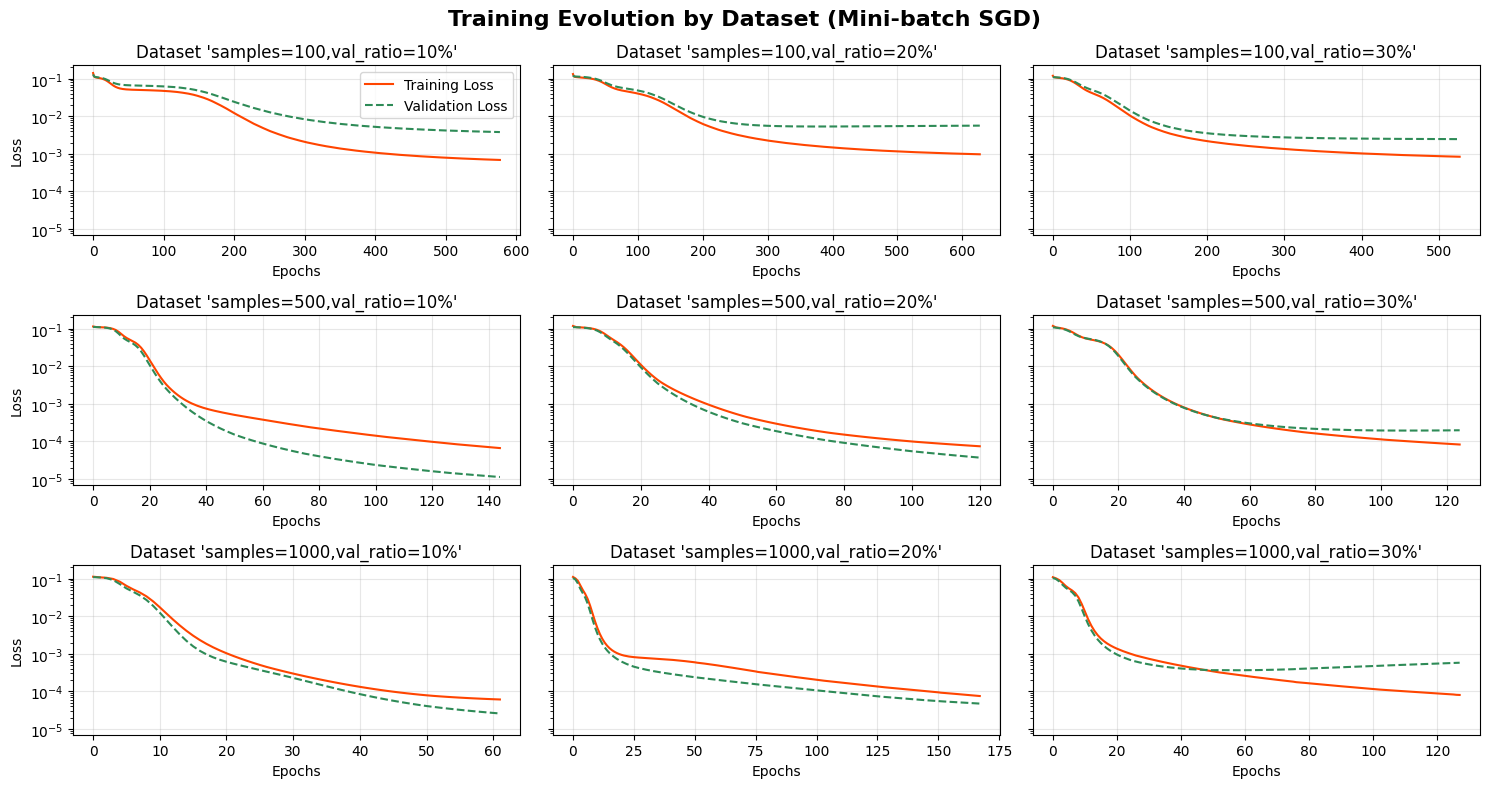

,Dataset,Accuracy (original),Accuracy (neuronas),Accuracy (lr_decay),Accuracy (mini-batch)
0,"samples=100,val_ratio=10%",0.900000,1.000000,1.000000,1.000000
1,"samples=100,val_ratio=20%",0.950000,0.950000,0.950000,0.950000
2,"samples=100,val_ratio=30%",0.933333,1.000000,1.000000,1.000000
3,"samples=1000,val_ratio=10%",0.990000,1.000000,1.000000,1.000000
4,"samples=1000,val_ratio=20%",0.980000,1.000000,1.000000,1.000000
5,"samples=1000,val_ratio=30%",0.986667,0.996667,0.996667,0.996667
6,"samples=500,val_ratio=10%",1.000000,1.000000,1.000000,1.000000
7,"samples=500,val_ratio=20%",0.980000,1.000000,1.000000,1.000000
8,"samples=500,val_ratio=30%",0.993333,1.000000,1.000000,1.000000


In [13]:
results = train_datasets(
    datasets,
    lambda: MLP2((100, 10, 10, 3), "sigmoid", 0.1 * np.sqrt(16), 0.1),
    train_kwargs={"tolerance": 0.000001, "lr_decay": 0.1, "batch_size": 16},
)

plot_training_evolution(results, title="Training Evolution by Dataset (Mini-batch SGD)")
accuracies["Accuracy (mini-batch)"] = compute_validation_accuracies(results, datasets)
accuracies

### Grid Search de Hiperparámetros

En el Notebook `grid_search.ipynb` se hace una búsqueda más exhaustiva para encontrar mejores hiperparámetros.
Se exportan todas las funciones y variables definidas en esta notebook para que luego se puedan importar desde `grid_search.ipynb`.

## 🎨 Interfaz de Usuario

Se implementa una interfaz de usuario para probar el modelo desarrollado y entrenado.

In [22]:
# Utilizar uno de los MLPs entrenados para la UI.
mlp2UI = None
for result in results:
    if result["dataset_name"] == "samples=1000,val_ratio=20%":
        mlp2UI = result["mlp"]

In [91]:
import gradio as gr
import numpy as np
from datetime import datetime


def generar_patron_con_ruido(
    letra_seleccionada: str, porcentaje_distorsion: float
) -> np.ndarray:
    """
    Genera un patrón de letra con distorsión aplicada.
    Args:
        letra_seleccionada: La letra a generar ('b', 'd' o 'f').
        porcentaje_distorsion: Porcentaje de distorsión (0-30).
    Returns:
        Matriz 10x10 con el patrón generado.
    """

    ruido = porcentaje_distorsion / 100.0

    patron_1d = generate_sample(letra_seleccionada, noise=ruido)
    patron_2d = patron_1d.reshape((10, 10))

    return patron_2d.astype(int)


def limpiar_tablero() -> np.ndarray:
    """
    Reinicia el tablero a una matriz vacía.
    Returns:
        Matriz 10x10 llena de ceros.
    """
    return np.zeros((10, 10), dtype=int)


def matriz_a_vector(matriz: np.ndarray) -> np.ndarray:
    """
    Convierte la matriz del tablero en un vector de 100 elementos,
    que es lo que el MLP espera como entrada.
    Args:
        matriz: Matriz 10x10 a convertir.
    Returns:
        Vector de 100 elementos (float64).
    """
    if isinstance(matriz, list):
        matriz = np.array(matriz)
    return matriz.flatten().astype(np.float64)


def vector_a_matriz(vector: np.ndarray) -> np.ndarray:
    """Convierte un vector de 100 elementos en una matriz 10x10."""
    if isinstance(vector, list):
        vector = np.array(vector)
    return vector.reshape((10, 10)).astype(np.float64)


def identificar_letra(
    matriz: np.ndarray, historial_actual: list, patron_esperado: str, distorsion: int
):
    """
    Usa el modelo MLP para identificar la letra en el tablero.
    La matriz del tablero se convierte a vector y se pasa al modelo.
    Args:
        matriz: Matriz 10x10 con el patrón a identificar.
        historial_actual: Lista con el historial de ejecuciones.
        patron_esperado: Letra esperada ('b', 'd', 'f') o "dibujado".
        distorsion: Nivel de distorsión aplicada (0-30) o -1 si es dibujado.
    Returns:
        Tupla con: (resultado_formatted, historial_actualizado).
    """
    vector = matriz_a_vector(matriz)

    prediccion = mlp2UI.classify(vector)

    # Para obtener las confianzas, hacemos un feedforward y obtenemos las salidas
    activaciones = mlp2UI.feedforward(vector)
    salidas = activaciones[-1]  # Salidas de la capa de salida [y_b, y_d, y_f]

    # Obtener la confianza de la letra predicha
    indice_predicho = CLASSES.index(prediccion)
    confianza_maxima = salidas[indice_predicho]

    # Normalizar las salidas para obtener "confianzas"
    suma_salidas = np.sum(salidas)
    if suma_salidas > 0:
        confianzas_normalizadas = salidas / suma_salidas
    else:
        confianzas_normalizadas = salidas

    # Formatear el resultado
    resultado = "Letra identificada:  \n\n"
    resultado += f"<p style='font-size: 4em; font-weight: bold; margin: 0px; text-align: center;'>{prediccion}</p>\n\n"
    resultado += "### Confianza:\n\n"

    for i, clase in enumerate(CLASSES):
        confianza = confianzas_normalizadas[i]
        barra = "█" * int(confianza * 20)
        resultado += f"- **{clase}**: {confianza:.1%} {barra}\n"

    # Agregar entrada al historial
    timestamp = datetime.now().strftime("%H:%M:%S")
    entrada_historial = {
        "hora": timestamp,
        "patron_esperado": patron_esperado,
        "distorsion": distorsion,
        "prediccion": prediccion,
        "confianza": f"{confianza_maxima:.1%}",
        "celdas_pintadas": int(np.sum(vector)),
    }

    nuevo_historial = historial_actual.copy() if historial_actual else []
    nuevo_historial.append(entrada_historial)

    # Mantener solo las últimas 20 ejecuciones
    if len(nuevo_historial) > 20:
        nuevo_historial = nuevo_historial[-20:]

    return resultado, nuevo_historial


def generar_tabla_historial(historial: list) -> str:
    """
    Genera una tabla HTML bonita con el historial de ejecuciones.
    Args:
        historial: Lista de diccionarios con las ejecuciones.
    Returns:
        String HTML con la tabla formateada.
    """
    if not historial:
        return """
        <div style="text-align: center; padding: 20px; color: #7f8c8d;">
            <p>Sin ejecuciones aún. ¡Identifica un patrón para comenzar!</p>
        </div>
        """

    # Crear tabla HTML
    html = """
    <div style="width: 100%; overflow-x: auto;">
        <table style="
            width: 100%;
            border-collapse: collapse;
            background-color: var(--input-background-fill);
            border-radius: 8px;
            overflow: hidden;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        ">
            <thead style="
                background-color: color-mix(in srgb, var(--background-fill-primary) 80%, #e0ddd5);
                color: var(--body-text-color);
                font-weight: 600;
                text-align: center;
                border-bottom: 2px solid var(--block-border-color);
                box-shadow: 0 1px 2px rgba(0,0,0,0.1);
            ">
                <tr>
                    <th style="padding: 12px; border: 1px solid #ddd; width: 12%;">Hora</th>
                    <th style="padding: 12px; border: 1px solid #ddd; width: 15%;">Patrón Esperado</th>
                    <th style="padding: 12px; border: 1px solid #ddd; width: 10%;">Distorsión</th>
                    <th style="padding: 12px; border: 1px solid #ddd; width: 13%;">Predicción</th>
                    <th style="padding: 12px; border: 1px solid #ddd; width: 28%;">Confianza</th>
                </tr>
            </thead>
            <tbody>
    """

    # Agregar filas en orden inverso (más recientes primero)
    for idx, ejecucion in enumerate(reversed(historial)):
        # Alternar colores de fila
        fila_bg = (
            "rgba(102, 126, 234, 0.1)" if idx % 2 == 0 else "rgba(118, 75, 162, 0.05)"
        )

        # Determinar color de confianza
        confianza_str = ejecucion["confianza"]
        confianza_num = float(confianza_str.rstrip("%")) / 100

        if confianza_num >= 0.8:
            color_confianza = "#27ae60"
        elif confianza_num >= 0.6:
            color_confianza = "#f39c12"
        else:
            color_confianza = "#e74c3c"

        # Crear barra de confianza
        barra_width = confianza_num * 100
        barra_html = f"""
        <div style="
            width: 100%;
            height: 24px;
            background-color: #ecf0f1;
            border-radius: 4px;
            overflow: hidden;
            display: flex;
            align-items: center;
            justify-content: center;
            font-weight: bold;
            font-size: 12px;
            color: white;
        ">
            <div style="
                width: {barra_width}%;
                height: 100%;
                background: linear-gradient(90deg, {color_confianza} 0%, {color_confianza}dd 100%);
                display: flex;
                align-items: center;
                justify-content: center;
                color: white;
                font-weight: bold;
            ">{confianza_str}</div>
            {f'<span style="position: absolute; color: #2c3e50;">{confianza_str}</span>' if barra_width < 30 else ""}
        </div>
        """

        # Formatear patrón esperado
        patron_display = ejecucion["patron_esperado"]
        if patron_display == "dibujado":
            patron_html = f"<span style='background-color: #95a5a6; color: white; padding: 4px 8px; border-radius: 4px; font-weight: bold;'>{patron_display}</span>"
        else:
            patron_html = f"<strong style='font-size: 18px;'>{patron_display}</strong>"

        # Formatear distorsión
        distorsion_valor = ejecucion["distorsion"]
        if distorsion_valor == -1:
            distorsion_display = "-"
        else:
            distorsion_display = f"{distorsion_valor}%"

        html += f"""
                <tr style="background-color: {fila_bg}; border-bottom: 1px solid #ddd;">
                    <td style="padding: 12px; border: 1px solid #ddd; text-align: center; font-weight: bold;">
                        {ejecucion["hora"]}
                    </td>
                    <td style="padding: 12px; border: 1px solid #ddd; text-align: center;">
                        {patron_html}
                    </td>
                    <td style="padding: 12px; border: 1px solid #ddd; text-align: center; font-weight: bold;">
                        {distorsion_display}
                    </td>
                    <td style="padding: 12px; border: 1px solid #ddd; text-align: center; font-size: 18px;">
                        <strong>{ejecucion["prediccion"]}</strong>
                    </td>
                    <td style="padding: 8px; border: 1px solid #ddd;">
                        {barra_html}
                    </td>
                </tr>
        """

    html += """
            </tbody>
        </table>
    </div>
    """

    return html


# =============================================================================
# INTERFAZ GRADIO
# =============================================================================

# CSS personalizado para mejorar el estilo
css_personalizado = """
* {
    box-sizing: border-box;
    --layout-gap: 20px;
}

#titulo-principal {
    text-align: center;
    font-size: 2.2em;
    font-weight: bold;
    color: #2c3e50;
}

#subtitulo {
    text-align: center;
    font-size: 0.95em;
    color: #7f8c8d;
}

#seccion-controles, #seccion-prediccion, #seccion-historial {
    background: var(--input-background-fill);
    border: 1px solid var(--block-border-color);
    padding: 20px;
    color: var(--body-text-color);
    box-shadow: var(--block-shadow);
}

#seccion-tablero {
    text-align: center;
    padding: 20px;
}

#seccion-historial {
    gap: 0px;
}
#titulo-historial {
    text-align: center;
    font-size: 1.5em;
    font-weight: bold;
    color: #2c3e50;
}

.gr-button-primary {
    background: linear-gradient(90deg, #00C9FF 0%, #92FE9D 100%);
    border: none;
    font-weight: bold;
}

.gr-button-secondary {
    background: linear-gradient(90deg, #FC466B 0%, #3F5EFB 100%);
    border: none;
    font-weight: bold;
}

/* CSS para los botones del grid */
.grid-container {
    display: grid;
    grid-template-columns: repeat(10, 35px);
    grid-template-rows: repeat(10, 35px);
    gap: 1px;
    border: 3px solid #2c3e50;
    border-radius: 10px;
    background: #e5e6e8;
    box-shadow: 0 4px 6px rgba(0,0,0,0.1);
    width: fit-content;
    margin: 0 auto;
    padding: 0;
    line-height: 0;
    font-size: 0;
    overflow: hidden;
}

.grid-btn {
    min-width: 35px;
    max-width: 35px;
    width: 35px;
    height: 35px;
    min-height: 35px;
    margin: 0;
    border-radius: 0;
    padding: 0;
    border: none;
    transition: all 0.2s ease;
    box-sizing: border-box;
    display: block;
}

.grid-btn:hover {
    transform: scale(1.05);
    box-shadow: 0 0 6px 3px rgba(0, 176, 80, 0.25);
    z-index: 10;
}

.btn-0 {
    background: white;
}

.btn-1 {
    background: var(--button-primary-background-fill);
}

#historial-tabla table th {
    text-align: center !important;
    vertical-align: middle;
}
"""

# Cerrar interfaz anterior si se vuelve a ejecutar esta celda.
if "interfaz" in globals():
    print("🔄 Cerrando la interfaz de Gradio anterior...")
    interfaz.close()  # noqa: F821

# Crear la interfaz
with gr.Blocks(
    css=css_personalizado,
    title="MLP - Reconocedor de Patrones",
    theme=gr.themes.Monochrome(),
) as interfaz:
    # Título principal
    gr.Markdown("# Perceptrón Multicapa", elem_id="titulo-principal")
    gr.Markdown(
        "Dibujá una letra (**b**, **d**, o **f**) en la matriz 10x10 para que el modelo la clasifique.",
        elem_id="subtitulo",
    )
    gr.Markdown("---")

    # Estados
    historial_estado = gr.State(value=[])
    patron_esperado_estado = gr.State(value="dibujado")
    distorsion_estado = gr.State(value=-1)

    # Estado interno del tablero (matriz 10x10). Se usa el patrón 'b' como estado inicial.
    matriz_estado = gr.State(value=vector_a_matriz(PATTERNS["b"]))

    # Layout principal con 3 columnas
    with gr.Row():
        # =====================================================================
        # COLUMNA IZQUIERDA: CONTROLES
        # =====================================================================
        with gr.Column(scale=1, elem_id="seccion-controles"):
            gr.Markdown("## 📝 Carga de Patrones")

            selector_letra = gr.Radio(
                choices=["b", "d", "f"],
                value="b",
                label="Patrón",
                info="Selecciona qué letra querés generar.",
            )

            slider_distorsion = gr.Slider(
                minimum=0,
                maximum=30,
                value=0,
                step=1,
                label="Distorsión (%)",
                info="30% = 15 celdas alteradas.",
                # Opciones avanzadas de formato
                show_label=True,
                container=True,
            )

            boton_generar = gr.Button("Generar patrón", variant="primary", size="lg")
            boton_limpiar = gr.Button("Limpiar lienzo", variant="secondary", size="lg")

        # =====================================================================
        # COLUMNA CENTRAL: TABLERO DE DIBUJO
        # =====================================================================
        with gr.Column(scale=2, elem_id="seccion-tablero"):
            gr.Markdown("## 🖌️ Matriz de Dibujo")
            gr.Markdown("Haz click en una celda para alternar su valor.")

            # Grid de botones clickeables
            with gr.Row(elem_classes=["grid-container"]):
                # Grid de 10x10 botones
                botones_grid = []
                for i in range(10):
                    fila_botones = []
                    for j in range(10):
                        btn = gr.ClearButton(
                            value="",
                            elem_classes=["grid-btn", "btn-0"],
                            scale=0,
                        )
                        fila_botones.append(btn)
                    botones_grid.append(fila_botones)

        # =====================================================================
        # COLUMNA DERECHA: PREDICCIÓN
        # =====================================================================
        with gr.Column(scale=1, elem_id="seccion-prediccion"):
            gr.Markdown("## 🎯 Predicción")
            resultado_prediccion = gr.Markdown(
                "Presioná el botón para clasificar el patrón.",
                elem_classes=["info-text"],
            )
            boton_identificar = gr.Button(
                "Identificar letra", variant="primary", size="lg"
            )

    # =========================================================================
    # SECCIÓN HISTORIAL (ANCHO COMPLETO)
    # =========================================================================
    with gr.Column(elem_id="seccion-historial"):
        gr.Markdown("## 📋 Historial de Ejecuciones", elem_id="titulo-historial")
        historial_display = gr.HTML(
            value=generar_tabla_historial([]), elem_id="historial-tabla"
        )

    # Lista plana de botones para facilitar actualizaciones
    botones_flat = [btn for fila in botones_grid for btn in fila]

    # =========================================================================
    # EVENTOS Y CONEXIONES
    # =========================================================================

    def alternar_celda(i, j, matriz_actual):
        if isinstance(matriz_actual, list):
            matriz_actual = np.array(matriz_actual)
        matriz_nueva = matriz_actual.copy()

        matriz_nueva[i, j] = 1 - matriz_nueva[i, j]

        return matriz_nueva

    # Conectar cada botón del grid
    for i in range(10):
        for j in range(10):

            def crear_handler(i, j):
                def handler(matriz):
                    nueva_matriz = alternar_celda(i, j, matriz)
                    updates = []
                    for ii in range(10):
                        for jj in range(10):
                            valor = int(nueva_matriz[ii, jj])
                            clase = f"btn-{valor}"
                            updates.append(gr.Button(elem_classes=["grid-btn", clase]))
                    return [nueva_matriz] + updates

                return handler

            botones_grid[i][j].click(
                fn=crear_handler(i, j),
                inputs=[matriz_estado],
                outputs=[matriz_estado] + botones_flat,
            )

    def generar_handler(letra, distorsion):
        nueva_matriz = generar_patron_con_ruido(letra, distorsion)

        updates = []
        for i in range(10):
            for j in range(10):
                valor = int(nueva_matriz[i, j])
                clase = f"btn-{valor}"
                updates.append(gr.Button(elem_classes=["grid-btn", clase]))
        return [nueva_matriz] + updates + [letra, distorsion]

    boton_generar.click(
        fn=generar_handler,
        inputs=[selector_letra, slider_distorsion],
        outputs=[matriz_estado]
        + botones_flat
        + [patron_esperado_estado, distorsion_estado],
    )

    def limpiar_todo(historial):
        nueva_matriz = limpiar_tablero()
        updates = []
        for i in range(10):
            for j in range(10):
                updates.append(gr.Button(elem_classes=["grid-btn", "btn-0"]))
        return (
            [nueva_matriz]
            + updates
            + ["Tablero limpiado. Cargue un nuevo patrón para identificarlo."]
            + [historial, "dibujado", -1]
        )

    boton_limpiar.click(
        fn=limpiar_todo,
        inputs=[historial_estado],
        outputs=[matriz_estado]
        + botones_flat
        + [
            resultado_prediccion,
            historial_estado,
            patron_esperado_estado,
            distorsion_estado,
        ],
    )

    def identificar_con_historial(matriz, historial, patron_esperado, distorsion):
        resultado, nuevo_historial = identificar_letra(
            matriz, historial, patron_esperado, distorsion
        )
        tabla_html = generar_tabla_historial(nuevo_historial)
        return resultado, nuevo_historial, tabla_html

    boton_identificar.click(
        fn=identificar_con_historial,
        inputs=[
            matriz_estado,
            historial_estado,
            patron_esperado_estado,
            distorsion_estado,
        ],
        outputs=[resultado_prediccion, historial_estado, historial_display],
    )

    def inicializar_tablero():
        """Inicializa el tablero con el estado inicial de la matriz"""
        updates = []
        for i in range(10):
            for j in range(10):
                valor = int(matriz_estado.value[i, j])
                clase = f"btn-{valor}"
                updates.append(gr.Button(elem_classes=["grid-btn", clase]))
        return [matriz_estado.value] + updates

    interfaz.load(fn=inicializar_tablero, outputs=[matriz_estado] + botones_flat)

    gr.Markdown("---")
    gr.Markdown(
        """
        <center>
            <strong>Equipo Lambda:</strong><br>
            Aldo Omar <strong>Andres</strong>,
            Sixto Feliciano <strong>Arrejin</strong>,
            Agustín Nicolás <strong>Bravo Pérez</strong>,
            Tobias Alejandro <strong>Maciel Meister</strong>,
            André Leandro <strong>San Lorenzo</strong>.
        </center>
        """
    )

print("🚀 Iniciando la interfaz de Gradio...")
interfaz.close()
interfaz.launch()

🔄 Cerrando la interfaz de Gradio anterior...
Closing server running on port: 7860
🚀 Iniciando la interfaz de Gradio...
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


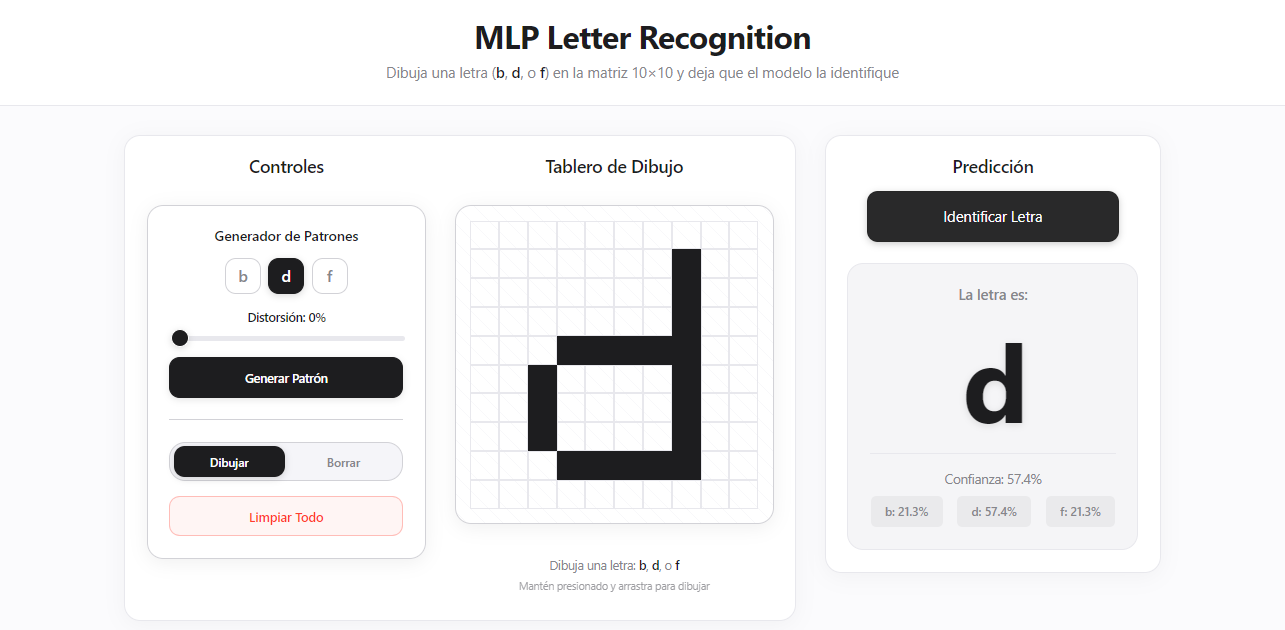